# Tutorial 9-2: Show and Tell – "Image Captioning with Attention"

**Course:** CSEN 342: Deep Learning  
**Topic:** Multimodal Learning, Spatial Attention, and Image Captioning

## Objective
In this tutorial, we will build a system that can look at an image and generate a sentence describing it. We will use the **Flickr8k** dataset.

**The Computational Challenge:**
Training a CNN-RNN pipeline end-to-end is very slow because running a ResNet on 8,000 images for every epoch is expensive. 

**The Solution:**
We will **pre-extract** the features. We run the CNN *once* over all images, save the output tensors (size $14 \times 14 \times 2048$) to disk, and then train our LSTM using these saved tensors. 

---

## Part 1: Data Setup (Download & Extract)

We check if the pre-processed features exist. If not, we download the raw images and process them.

**Instructor Note:** On the HPC, you can run this block once and move the `flickr8k` folder to a shared directory.

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import json
from tqdm import tqdm

# --- CONFIGURATION ---
# If you have a shared folder on the HPC, change this path!
SHARED_DATA_ROOT = '/data/shared/flickr8k_features'
LOCAL_DATA_ROOT = '../data/flickr8k'

# Determine where to look/save
if os.path.exists(SHARED_DATA_ROOT) and os.path.exists(os.path.join(SHARED_DATA_ROOT, 'features.pkl')):
    print(f"Found shared data at {SHARED_DATA_ROOT}")
    DATA_PATH = SHARED_DATA_ROOT
else:
    print(f"Shared data not found. Using local path: {LOCAL_DATA_ROOT}")
    DATA_PATH = LOCAL_DATA_ROOT
    os.makedirs(DATA_PATH, exist_ok=True)

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def download_flickr8k():
    """Downloads raw images and captions from stable mirror."""
    img_zip = os.path.join(DATA_PATH, 'Flickr8k_Dataset.zip')
    txt_zip = os.path.join(DATA_PATH, 'Flickr8k_text.zip')
    
    if not os.path.exists(os.path.join(DATA_PATH, 'Flicker8k_Dataset')):
        print("Downloading Images (1GB)... this may take a while.")
        os.system(f"wget -nc -P {DATA_PATH} https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip")
        print("Unzipping Images...")
        os.system(f"unzip -q {img_zip} -d {DATA_PATH}")
        
    if not os.path.exists(os.path.join(DATA_PATH, 'Flickr8k.token.txt')):
        print("Downloading Captions...")
        os.system(f"wget -nc -P {DATA_PATH} https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip")
        print("Unzipping Captions...")
        os.system(f"unzip -q {txt_zip} -d {DATA_PATH}")
        
    print("Raw data ready.")

def extract_features():
    """Runs ResNet-101 on all images and saves features to disk."""
    features_path = os.path.join(DATA_PATH, 'features.pkl')
    if os.path.exists(features_path):
        print("Features already extracted.")
        return

    print("Extracting features from images... (This happens once)")
    # Load Pre-trained ResNet
    try:
        resnet = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
    except Exception:
        model_path = '../data/resnet101-63fe2227.pth'
        if not os.path.exists(model_path):
            os.system(f"wget -nc -P ../data/ https://download.pytorch.org/models/resnet101-63fe2227.pth")
        state_dict = torch.load(model_path)
        resnet = models.resnet101(weights=None)
        resnet.load_state_dict(state_dict)
    # Remove the last two layers (avgpool and fc) to keep the 14x14 grid
    modules = list(resnet.children())[:-2]
    encoder = nn.Sequential(*modules).to(device)
    encoder.eval()
    
    transform = transforms.Compose([
        transforms.Resize((448, 448)), # Larger size for better grid resolution
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    img_dir = os.path.join(DATA_PATH, 'Flicker8k_Dataset')
    features = {}
    
    img_files = os.listdir(img_dir)
    # Process in batches would be faster, but loop is simpler for tutorial code
    for i, filename in enumerate(tqdm(img_files)):
        if not filename.endswith('.jpg'): continue
        
        path = os.path.join(img_dir, filename)
        img = Image.open(path).convert('RGB')
        img = transform(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            # Output: (1, 2048, 14, 14)
            feature = encoder(img)
            # Reshape to (14x14, 2048) -> (196, 2048) for easier attention
            feature = feature.squeeze(0).permute(1, 2, 0).view(-1, 2048)
            
        features[filename] = feature.cpu().numpy()
        
    with open(features_path, 'wb') as f:
        pickle.dump(features, f)
    print(f"Saved features for {len(features)} images.")

# Run setup
download_flickr8k()
extract_features()

Shared data not found. Using local path: ../data/flickr8k
Raw data ready.
Extracting features from images... (This happens once)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /tmp/xdgcache-danastasiu/torch/hub/checkpoints/resnet101-63fe2227.pth
/local/scratch/175433/ipykernel_2443159/2262091130.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

Saved features for 8091 images.


---

## Part 2: Caption Preprocessing

We need to parse the `Flickr8k.token.txt` file, build a vocabulary, and tokenize the sentences.

In [7]:
from collections import Counter
class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self): return len(self.itos)

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            for word in sentence.lower().split():
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = text.lower().split()
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

# Load Captions
captions_file = os.path.join(DATA_PATH, 'Flickr8k.token.txt')
all_captions = []
img_caps_map = {}

with open(captions_file, 'r') as f:
    for line in f:
        tokens = line.strip().split('\t')
        if len(tokens) < 2: continue
        img_id = tokens[0].split('#')[0]
        caption = tokens[1]
        all_captions.append(caption)
        if img_id not in img_caps_map:
            img_caps_map[img_id] = []
        img_caps_map[img_id].append(caption)

vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(all_captions)

print(f"Vocabulary Size: {len(vocab)}")
print("Sample Caption:", all_captions[0])

Vocabulary Size: 3005
Sample Caption: A child in a pink dress is climbing up a set of stairs in an entry way .


---

## Part 3: The Dataset Class

This loads the pre-extracted features and numericalized captions.

In [8]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_map, vocab, features_path):
        self.root_dir = root_dir
        self.captions_map = captions_map
        self.vocab = vocab
        
        # Load features into memory (might be large, ~1.5GB for 8k images)
        # If OOM, you can load individual files in __getitem__ instead
        with open(features_path, 'rb') as f:
            self.features = pickle.load(f)
            
        # Flatten (Image, Caption) pairs
        self.data = []
        for img_id, caps in captions_map.items():
            if img_id in self.features: # Ensure we have the feature
                for cap in caps:
                    self.data.append((img_id, cap))

    def __len__(self): return len(self.data)

    def __getitem__(self, index):
        img_id, caption = self.data[index]
        
        # Get feature: (196, 2048)
        feature = torch.tensor(self.features[img_id], dtype=torch.float)
        
        # Process Caption
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return feature, torch.tensor(numericalized_caption)

# Collate function to pad sentences in the batch
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    features = [item[0] for item in batch]
    captions = [item[1] for item in batch]
    
    features = torch.stack(features)
    captions = pad_sequence(captions, batch_first=True, padding_value=vocab.stoi["<PAD>"])
    
    return features, captions

# Create Loader
dataset = FlickrDataset(DATA_PATH, img_caps_map, vocab, os.path.join(DATA_PATH, 'features.pkl'))
loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

---

## Part 4: The Attention Model

We use "Soft Attention" (Bahdanau). The model attends to the 196 locations in the feature map.

In [9]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        # encoder_out: (Batch, 196, 2048)
        # decoder_hidden: (Batch, 512)
        
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        
        # Weighted sum: (Batch, 196, 1) * (Batch, 196, 2048) -> (Batch, 2048)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return context, alpha

class DecoderRNN(nn.Module):
    def __init__(self, embed_dim, attention_dim, decoder_dim, vocab_size, encoder_dim=2048):
        super(DecoderRNN, self).__init__()
        self.vocab_size = vocab_size
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(0.5)
        self.lstm_cell = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.fc = nn.Linear(decoder_dim, vocab_size)

    def init_hidden(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, features, captions):
        # features: (Batch, 196, 2048)
        # captions: (Batch, Seq_Len)
        
        batch_size = features.size(0)
        seq_len = captions.size(1) - 1
        
        embeds = self.embedding(captions)
        h, c = self.init_hidden(features)
        
        predictions = torch.zeros(batch_size, seq_len, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_len, 196).to(device)
        
        for t in range(seq_len):
            context, alpha = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, t], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fc(self.dropout(h))
            
            predictions[:, t] = output
            alphas[:, t] = alpha
            
        return predictions, alphas

---

## Part 5: Training

We train the model. Since we pre-extracted features, this will be surprisingly fast.

In [11]:
import torch.optim as optim

model = DecoderRNN(embed_dim=256, attention_dim=256, decoder_dim=512, vocab_size=len(vocab)).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])

print("Starting Training...")
model.train()
for epoch in range(1): # 1 Epoch for tutorial speed
    for i, (features, captions) in enumerate(loader):
        features, captions = features.to(device), captions.to(device)
        
        optimizer.zero_grad()
        outputs, _ = model(features, captions)
        
        # Flatten for loss: (Batch*Seq, Vocab)
        targets = captions[:, 1:] # Shift target
        loss = criterion(outputs.reshape(-1, len(vocab)), targets.reshape(-1))
        
        loss.backward()
        optimizer.step()
        
        if i % 50 == 0:
            print(f"Step {i}/{len(loader)}, Loss: {loss.item():.4f}")

print("Training Complete.")

Starting Training...
Step 0/1265, Loss: 8.0332
Step 50/1265, Loss: 5.0274
Step 100/1265, Loss: 4.4345
Step 150/1265, Loss: 4.3178
Step 200/1265, Loss: 4.2147
Step 250/1265, Loss: 4.0510
Step 300/1265, Loss: 4.0928
Step 350/1265, Loss: 3.9999
Step 400/1265, Loss: 3.8381
Step 450/1265, Loss: 3.5882
Step 500/1265, Loss: 3.5846
Step 550/1265, Loss: 3.6634
Step 600/1265, Loss: 3.6864
Step 650/1265, Loss: 3.8082
Step 700/1265, Loss: 3.5852
Step 750/1265, Loss: 3.5066
Step 800/1265, Loss: 3.5005
Step 850/1265, Loss: 3.5534
Step 900/1265, Loss: 3.5045
Step 950/1265, Loss: 3.3019
Step 1000/1265, Loss: 3.1459
Step 1050/1265, Loss: 2.9799
Step 1100/1265, Loss: 3.3864
Step 1150/1265, Loss: 3.0450
Step 1200/1265, Loss: 3.3081
Step 1250/1265, Loss: 3.2403
Training Complete.


## Part 6: Visualize Attention

Let's check what the model is looking at.

Generated Caption: a little girl in a red shirt is sitting on a bench .


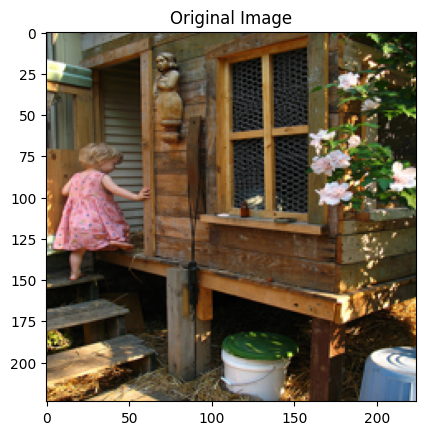

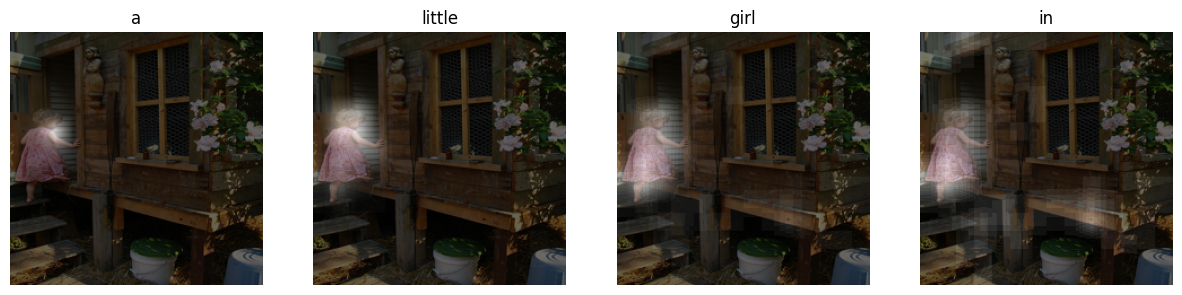

In [12]:
# Get a sample
img_id, _ = dataset.data[0]
img_path = os.path.join(DATA_PATH, 'Flicker8k_Dataset', img_id)
feature = torch.tensor(dataset.features[img_id]).unsqueeze(0).to(device)

# Generate Caption
model.eval()
with torch.no_grad():
    # Dummy start caption
    start_cap = torch.tensor([[vocab.stoi["<SOS>"]]]).to(device)
    h, c = model.init_hidden(feature)
    
    generated_words = []
    attentions = []
    
    # Greedy generation
    current_input = start_cap[:, 0]
    for _ in range(20):
        embeddings = model.embedding(current_input)
        context, alpha = model.attention(feature, h)
        lstm_input = torch.cat((embeddings, context), dim=1)
        h, c = model.lstm_cell(lstm_input, (h, c))
        output = model.fc(h)
        
        _, predicted = output.max(1)
        if predicted.item() == vocab.stoi["<EOS>"]: break
        
        generated_words.append(vocab.itos[predicted.item()])
        attentions.append(alpha.cpu().numpy())
        current_input = predicted

# Visualize
print("Generated Caption:", " ".join(generated_words))
image = Image.open(img_path).resize((224, 224))
plt.imshow(image)
plt.title("Original Image")
plt.show()

# Show first 4 words attention
fig = plt.figure(figsize=(15, 5))
for i in range(min(4, len(generated_words))):
    ax = fig.add_subplot(1, 4, i+1)
    ax.set_title(generated_words[i])
    att = attentions[i].reshape(14, 14)
    # Resize attention map to image size
    att_img = Image.fromarray((att * 255).astype('uint8')).resize((224, 224), resample=Image.BILINEAR)
    ax.imshow(image)
    ax.imshow(att_img, cmap='gray', alpha=0.6)
    ax.axis('off')
plt.show()